# Speed Dating Experiment

This project uses data from the [speed dating experiment dataset](https://www.kaggle.com/annavictoria/speed-dating-experiment) on Kaggle. Using information about daters and their partners, can we predict whether they wanted to see each other again?

In [ ]:
import numpy as np
import pandas as pd
import gzip
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.manifold import TSNE
import random
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from skimage import color
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
import cv2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,RocCurveDisplay,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc,f1_score
from sklearn.calibration import CalibratedClassifierCV
import time


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

# Some warnings tend to pop up during grid search
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Pre-wrangled, using the steps below
data = pd.read_csv('Speed Dating Data.csv', encoding='latin-1')

print(data.shape[0], 'observations and', data.shape[1], 'features')

8378 observations and 195 features


In [ ]:
# What kind of data are we dealing with?
data.dtypes.value_counts()

float64    174
int64       13
object       8
dtype: int64

In [ ]:
# Men (1) and women (0)
data.groupby('iid').mean().gender.value_counts()

1.0    277
0.0    274
Name: gender, dtype: int64

In [ ]:
# What percentage of pairs resulted in a match?
data['match'].value_counts(normalize=True)

0    0.835283
1    0.164717
Name: match, dtype: float64

About 16% of pairs resulted in a match -- a bit higher than I expected!

Using the Synthetic Minority Oversampling Technique (SMOTE) inside of the **`imbalanced-learn`** library can create new data points that resemble existing ones (using a k-nearest neighbors algorithm). I tried this in an earlier draft of the project, but it didn't lead to a significant increase in my model's performance. Trying it, however, was a great learning experience and gave me a new tool in my machine learning toolbox!

In [ ]:
# Getting a rough feel for how the data looks
data.head(1)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


*This* dataset contains multiple speed dating events, and a few measured people's personalities differently.

In all cases, participants had to rate how important different qualities in a parter were (such as ambition, sincerity, intelligence, etc.).

Some events gave people 100 points to distribute over these qualities, while others simply asked people to rate their importance from 1-10. Upon extensive testing, I found that removing the less-common scoring method resulted in a better model. Conversely, trying to normalize both methods didn't work quite as well.

In [ ]:
# Waves 6-11 rated importance, others allocated 100 points
points = (data.wave != 6 ) &\
    (data.wave != 7 ) &\
    (data.wave != 8 ) &\
    (data.wave != 9 ) &\
    (data.wave != 10 ) &\
    (data.wave != 11 )

data = data[points]

**Certain features are a little too similar to the target variable (whether there was a match). I'm electing to remove them, because I don't think it's interesting to predict matches based, for instance, on someone's response to the question, "How attracted are you to this person?" (That's too easy!)**

**The data I *will* use here is the average rating of each participant, as determined by how often his or her partners wanted to see them again. This gives us a rough estimate of each person's desirability, which is important since birds of a feather flock together.**

**Similarly, I'll look at how "choosy" someone was -- were they interested in every person they met, or hardly anyone? I think this data is fair game for the machine learning task, since a dating website would have similar statistics.**

In [ ]:
desirability = data.groupby('iid').mean()['dec_o'].to_dict()
data['desirability'] = data['iid'].map(desirability)

choosiness = data.groupby('iid').mean()['dec'].to_dict()
data['choosiness'] = data['iid'].map(choosiness)

In [ ]:
match_corrs = data.select_dtypes(include=[np.number])\
.corrwith(data.match)\
.sort_values(ascending=False)

match_corrs = match_corrs[match_corrs > .25].index

data = data.dropna(subset=['id', 'pid'], axis=0)

for i in match_corrs[1:]:
    del data[i]

# Other columns that are too predictive
del data['int_corr']
del data['them_cal']
del data['you_call']

del data['field'] # redundant

match_corrs

Index(['match', 'dec_o', 'dec', 'like_o', 'like', 'fun_o', 'fun', 'shar_o',
       'shar', 'attr_o', 'attr', 'prob_o', 'prob'],
      dtype='object')

This is a dirty dataset that needs to be cleaned. The first thing we'll do is fix the columns that are strings but should be numbers. I'm replacing the null values with -100 in anticipation of using a tree-based algorithm. A quick cross-validation showed that this strategy is better than using the feature's mean or median value.

In [ ]:
def fix_numeric(col, df=data, median=False):
    try:
        df[col] = df[col].str.replace(',', '')
    except:
        print('Column is not a string!')
    
    df[col] = df[col].astype(float)
    
    if median:
        df[col] = df[col].fillna(data.fillna.median())
    
    else:
        df[col] = df[col].fillna(-100)
    
    return df

for i in 'zipcode mn_sat tuition income'.split():
    data = fix_numeric(i)

Next we'll convert all string-based columns to lower case so we can process the data more reliably.

In [ ]:
for i in data.columns:
    if data[i].dtype == "O":
        data[i] = data[i].str.lower()
        print(i, end=', ')

undergra, from, career, 

# Benchmark

ROC-AUC has turned out to be the best metric to use for this project, and a naive predictor will always obtain a ROC-AUC score of 0.5. Nonetheless, let's run to the code to make it official.

In [ ]:
from sklearn.dummy import DummyClassifier

data_benchmark = pd.get_dummies(data)
data_benchmark.fillna(data_benchmark.median(), inplace=True)

xbench = data_benchmark.drop('match', axis=1)
ybench = data_benchmark['match']

dum = DummyClassifier(strategy='constant', constant=1)

cvs = cross_val_score(dum, xbench, ybench, scoring='roc_auc', cv=5)

benchmark_score = cvs.mean()

print('Naive Benchmark:', benchmark_score)

Naive Benchmark: 0.5


# Feature Engineering
And now we'll engineer some new features based on people's responses to the open-ended questions.

I examined people's responses to the three features "from," "undergra(d)," and "career," and combined some of the more common answers into a single variable. First we set the default value to zero, and then overwrite it with a 1 when a response matches the strings listed.

In [ ]:
data['from_new_england'] = 0
for i in 'massachu connect rhode vermont vt hampsh maine boston cambridge'.split():
    data['from_new_england'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                        data['from_new_england'])
    
data['from_china'] = 0
for i in 'china beijing shanghai hong taiwan'.split():
    data['from_china'] = np.where((data['from'].str.contains(i)) |\
                                  (data['undergra'].str.contains(i)), 1,
                                  data['from_china'])

data['from_india'] = 0
for i in 'india delhi bangalore'.split():
    data['from_india'] = np.where((data['from'].str.contains(i)) |\
                                  (data['undergra'].str.contains(i)), 1,
                                  data['from_india'])
    
data['from_europe'] = 0
for i in 'europe germany italy france spain poland portugal netherlands holland sweden switz greece belgium paris rome'.split():
    data['from_europe'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                   data['from_europe'])

data['from_uk'] = 0
for i in 'london england uk britain scotland ireland kingdom oxford'.split():
    data['from_uk'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                               data['from_uk'])

data['from_ny'] = 0
for i in ['new york', 'ny']:
    data['from_ny'] = np.where((data['from'].str.contains(i)) |\
                               (data['undergra'].str.contains(i)), 1,
                               data['from_ny'])

data['from_nj'] = 0
for i in ['new jersey', 'nj']:
    data['from_nj'] = np.where((data['from'].str.contains(i)) |\
                               (data['undergra'].str.contains(i)), 1,
                               data['from_nj'])

data['from_california'] = 0
for i in 'cali diego francisco jose davis sacramento oakland clara angeles ucla stanford berkeley alto torrance'.split():
    data['from_california'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                       data['from_california'])
    
data['from_texas'] = 0
for i in 'texas tx dallas austin houston dfw antonio'.split():
    data['from_texas'] = np.where((data['from'].str.contains(i)) |\
                                   (data['undergra'].str.contains(i)), 1,
                                  data['from_texas'])
    

Now let's do something similar with careers.

In [ ]:
data['career_education'] = 0
for i in 'professor teach academ educ'.split():
    data['career_education'] = np.where(data['career'].str.contains(i),
                                        1, data['career_education'])

data['career_law'] = 0
for i in 'law attorney legal defender counsel'.split():
    data['career_law'] = np.where(data['career'].str.contains(i),
                                  1, data['career_law'])

data['career_medicine'] = 0
for i in 'doctor dr physician md medical m.d. cardio dentist surg'.split():
    data['career_medicine'] = np.where(data['career'].str.contains(i),
                                       1, data['career_medicine'])

data['career_business'] = 0
for i in 'business mba m.b.a. consult manage ceo c.e.o. entre finance venture market strategy invest bank equity'.split():
    data['career_business'] = np.where(data['career'].str.contains(i),
                                       1, data['career_business'])
    
data['career_science'] = 0
for i in 'sci research biolo chemi'.split():
    data['career_science'] = np.where(data['career'].str.contains(i),
                                      1, data['career_science'])

data['career_gov'] = 0
for i in 'gov diplo poli'.split():
    data['career_gov'] = np.where(data['career'].str.contains(i),
                                  1, data['career_gov'])


And schools. The data is from Columbia, so I thought it deserved its own feature. Other than that, I think it's only the other Ivy League schools that are noteworthy here (we've already used schools to determine where people are from).

In [ ]:
data['school_columbia'] = 0
for i in 'columbia'.split():
    data['school_columbia'] = np.where(data['undergra'].str.contains(i),
                                       1, data['school_columbia'])

# Ivy league and other prestigious schools
data['school_ivy'] = 0
for i in 'dartmouth cornell princeton penn yale brown harvard stanford mit berkeley oxford'.split():
    data['school_ivy'] = np.where(data['undergra'].str.contains(i),
                                  1, data['school_ivy'])

Time to dummify our remaining data and do some final tidying up.

In [ ]:
# Dummify
data = pd.get_dummies(data, prefix='dummy')

# Some Stackoverflow code to fix duplicate column names
cols = pd.Series(data.columns)

for dup in cols[cols.duplicated()]:
    cols[data.columns.get_loc(dup)] =\
    [dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(data.columns.get_loc(dup).sum())]

data.columns = cols

data.shape

(5761, 822)

We have a lot of null values in this dataset. After some experimentation, I found that predicting them using a regressor was the best strategy. The main thing we have to be careful about is not using our target variable to regress these values -- that would be looking into the future and would contaminate our dataset.

I chose to use a k-neighbors regressor because it's computationally cheap and there is a lot of data to process.

In [ ]:
# Just a sample of how much missing data we have.
data.isnull().sum().sort_values(ascending=False)[:10]

num_in_3    5278
numdat_3    5067
attr2_3     4271
attr7_3     4271
sinc7_3     4271
intel7_3    4271
fun7_3      4271
amb7_3      4271
shar7_3     4271
attr4_3     4271
dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

# Get null columns
null_cols = data.isnull().sum()
null_cols = list(null_cols[null_cols != 0].index)

for i in null_cols:
    #print(i, 'has', data[i].isnull().sum(), 'missing values')
    x = data.fillna(data.mean()).drop(['match', 'id'], axis=1)
    y = x.pop(i)
    
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
    reg = KNeighborsRegressor()
    reg.fit(xtrain, ytrain)      
    pred = reg.predict(xtest)
    r2 = r2_score(ytest, pred)
    
    # If we can reasonably predict these values, do so
    if r2 > .20:
        #print('regressing', i, 'with an r2 of', round(r2, 3))
        data['predicted'] = reg.predict(data.fillna(data.median()).drop([i, 'match', 'id'], axis=1))
        data[i] = np.where(data[i].isnull(), data['predicted'], data[i])
        del data['predicted']
    
    # Otherwise, just take the median
    else:
        #print('averaging', i)
        data[i] = data[i].fillna(data[i].median())
    #print()

Let's add more features. We're vastly increasing the dimensionality of the data, but we'll try dimensionality reduction techniques later and cross-validate them.

In [ ]:
def get_partner_data(pid, col):
    '''Looks up the person's partner and adds their data
    as new features. If the partner ID doesn't exist,
    returns a -1.'''
    try:
        partner = data[data['iid'] == pid].head(1)[col].iloc[0]
        if partner:
            return partner
        else:
            return -1
    except:
        return -1

# Income (where income data is available, take the log difference)
data['partner_income'] = data['pid'].apply(get_partner_data, col='income')
data['income_difference'] = np.where((data.partner_income == -1) |\
                                     (data.income == -1),
                                     -1, np.log1p(np.abs(data.income - data.partner_income)))

# Age
data['age'].fillna(data['age'].median(), inplace=True)
data['age_o'].fillna(data['age_o'].median(), inplace=True)
data['age_difference'] = data['age'] - data['age_o']

In [ ]:
# This is important: compare the each person's overall desirability to their partner's.

data['partner_desirability'] = data['pid'].apply(get_partner_data, col='desirability')

data['des_diff'] = data['desirability'] - data['partner_desirability']

# Also for Choosiness

data['partner_choosiness'] = data['pid'].apply(get_partner_data, col='choosiness')

data['choose_diff'] = data['choosiness'] - data['partner_choosiness']

There was a *lot* of data gathered at these events; probably more than necessary. Not only were participants rating the importance of these qualities in others, but they also:

- Rated themselves
- Rated how they think *others* might score them
- Updated their ratings midway through the speed-dating event

I believe the fundamentally important information is how a partner stacked up against someone's expectations. So we'll definitely calculate that. But we'll also do it in **two** ways, because people updated their self-ratings midway through.

It's complicated and I don't agree with the study's methodology, but we should make use of all the data we have.

In [ ]:
# Attractiveness
data['partner_attractiveness'] = data['pid'].apply(get_partner_data, col='attr3_1')
data['attr_expectations'] = (10*data['attr1_1']/data['attr1_1'].max()) -\
                                     data['partner_attractiveness']
data['partner_attractiveness_2'] = data['pid'].apply(get_partner_data, col='attr5_1')
data['attr_expectations_2'] = (10*data['attr1_1']/data['attr1_1'].max()) -\
                                       data['partner_attractiveness_2']

# Intelligence
data['partner_intelligence'] = data['pid'].apply(get_partner_data, col='intel3_1')
data['intel_expectations'] = (10*data['intel1_1']/data['intel1_1'].max()) -\
                                     data['partner_intelligence']
data['partner_intelligence_2'] = data['pid'].apply(get_partner_data, col='intel5_1')
data['intel_expectations_2'] = (10*data['intel1_1']/data['intel1_1'].max()) -\
                                       data['partner_intelligence_2']

# Fun
data['partner_fun'] = data['pid'].apply(get_partner_data, col='fun3_1')
data['fun_expectations'] = (10*data['fun1_1']/data['fun1_1'].max()) -\
                                     data['partner_fun']
data['partner_fun_2'] = data['pid'].apply(get_partner_data, col='fun5_1')
data['fun_expectations_2'] = (10*data['fun1_1']/data['fun1_1'].max()) -\
                                       data['partner_fun_2']

# Ambitious
data['partner_ambition'] = data['pid'].apply(get_partner_data, col='amb3_1')
data['amb_expectations'] = (10*data['amb1_1']/data['amb1_1'].max()) -\
                                     data['partner_ambition']
data['partner_ambition_2'] = data['pid'].apply(get_partner_data, col='amb5_1')
data['amb_expectations_2'] = (10*data['amb1_1']/data['amb1_1'].max()) -\
                                       data['partner_ambition_2']

# Sincerity
data['partner_sincerity'] = data['pid'].apply(get_partner_data, col='sinc3_1')
data['sinc_expectations'] = (10*data['sinc1_1']/data['sinc1_1'].max()) -\
                                     data['partner_sincerity']
data['partner_sincerity_2'] = data['pid'].apply(get_partner_data, col='sinc5_1')
data['sinc_expectations_2'] = (10*data['sinc1_1']/data['sinc1_1'].max()) -\
                                       data['partner_sincerity_2']

We're going to calculate expectations one last way: by binning traits into "above average" and "below average" and seeing how each pair stacks up. We'll assign a "1" when a partner meets or exceeds someone's expectations, and a "0" otherwise.

I'm also going to try comparing ambition importance to the partner's socioeconomic status (zip code average income). Maybe this will be more important than simply whether someone *says* they're ambitious.

In [ ]:
# Measuring expectations one more way

data['attr_above_avg'] = np.where(data['partner_attractiveness'] > data['partner_attractiveness'].mean(),
                                  1, 0)
data['attr_imp_above_avg']= np.where(data['attr1_1'] > data['attr1_1'].mean(),
                                     1, 0)
data['attr_match'] = np.where(data['attr_above_avg'] >= data['attr_imp_above_avg'],
                             1, 0)

data['sinc_above_avg'] = np.where(data['partner_sincerity'] > data['partner_sincerity'].mean(),
                                  1, 0)
data['sinc_imp_above_avg']= np.where(data['sinc1_1'] > data['sinc1_1'].mean(),
                                     1, 0)
data['sinc_match'] = np.where(data['sinc_above_avg'] >= data['sinc_imp_above_avg'],
                             1, 0)

data['int_above_avg'] = np.where(data['partner_intelligence'] > data['partner_intelligence'].mean(),
                                  1, 0)
data['int_imp_above_avg']= np.where(data['intel1_1'] > data['intel1_1'].mean(),
                                     1, 0)
data['int_match'] = np.where(data['int_above_avg'] >= data['int_imp_above_avg'],
                             1, 0)

data['fun_above_avg'] = np.where(data['partner_fun'] > data['partner_fun'].mean(),
                                  1, 0)
data['fun_imp_above_avg']= np.where(data['fun1_1'] > data['fun1_1'].mean(),
                                     1, 0)
data['fun_match'] = np.where(data['fun_above_avg'] >= data['fun_imp_above_avg'],
                             1, 0)

In [ ]:
# Ambition (recall we're doing this one differently)

# Temporarily replace missing values with the median
data['income_temp'] = np.where(data['income'] == -100, data['income'].median(), data['income'])

data['income_above_avg']= np.where(data['income_temp'] > data['income_temp'].median(), 1, 0)
data['partner_income_above_avg'] = data['pid'].apply(get_partner_data, col='income_above_avg')

data['amb_imp_above_avg'] = np.where(data['amb1_1'] > data['amb1_1'].mean(), 1, 0)

data['amb_match'] = np.where(data['partner_income_above_avg'] >= data['amb_imp_above_avg'],
                             1, 0)
del data['income_temp']

Now let's add some more information about people's partners. If a participant and their partner both went to the same school, are from the same place, or have similar career ambitions, we'll assign a "1" for that feature, otherwise we'll assign a "0."

In [ ]:
cols = data.columns

for i in cols:
    if 'from_' in i:
        data['partner_loc'] = data['pid'].apply(get_partner_data, col=i)
        data['both_' + i] = np.where((data[i] == 1) & (data['partner_loc'] == 1), 1, 0)
        del data['partner_loc']
        
for i in cols:
    if 'school_' in i:
        data['partner_edu'] = data['pid'].apply(get_partner_data, col=i)
        data['both_' + i] = np.where((data[i] == 1) & (data['partner_edu'] == 1), 1, 0)
        del data['partner_edu']
        
for i in cols:
    if 'career_' in i:
        data['partner_car'] = data['pid'].apply(get_partner_data, col=i)
        data['both_' + i] = np.where((data[i] == 1) & (data['partner_car'] == 1), 1, 0)
        del data['partner_car']

And now do something similar for hobbies.

In [ ]:
hobbies = ['go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
 'movies', 'concerts', 'music', 'shopping', 'yoga']

for i in hobbies:
    data['partner_' + i] = data['pid'].apply(get_partner_data, col=i)
    data[i + '_in_common'] = np.where((data[i] > 7) & (data['partner_' + i] > 7), 1, 0)
    del data['partner_' + i]

Dimensionality is increasing quickly. Let's remove dummies where only a single person has a "1." My testing showed that this improved the model's performance.

In [ ]:
counts =\
data.groupby('iid').mean().sum(axis=0).sort_values()

deleted = []

for i in counts[counts < 2].index:
    if 'dummy_' in i:
        deleted.append(i)
        del data[i]

# Fix anything that got counted twice
for i in data.columns:
    if 'dummy_' in i:
        data[i] = np.where(data[i] >= 1, 1, 0)

In [ ]:
# Nearly 500 features removed. Not bad!
print('Deleted:', len(deleted))
print('Data shape:', data.shape)

Deleted: 489
Data shape: (5761, 412)


After several dozen hours of grid searching and trying to improve my model's performance, I finally went all-out and just appended *all* the partner data. My intuition that feature selection and machine learning would figure out what to do with this additional data was correct.

I would generally be more selective in situations like this, but I cross-validated and this strategy worked.

In [ ]:
cols = data.drop(['match', 'pid'], axis=1).columns
for i in cols:
    try:
        data['pid'].apply(get_partner_data, col=i)
    except:
        continue

One last feature to engineer: processing zip code data.

This was an interesting case. Originally, I planned to compare zip codes to see how far apart people grew up. It would be something along the lines of:

- 5 digits in common: Same neighborhood
- 4 digits in common: Same city
- 3 digits in common: Same state

and so on. But what I found was that comparing zip codes like this actually *reduced* our model's accuracy, while simply breaking down zip code components and adding the partner's data improved it.

So the code below might seem odd, but it leads to a marginal improvement in performance.

In [ ]:
data['zipcode'] = data['zipcode'].astype(str)
data['zip_5'] = (data['zipcode'].str[:5]).astype(float)
data['zip_4'] = (data['zipcode'].str[:4]).astype(float)
data['zip_3'] = (data['zipcode'].str[:3]).astype(float)
data['zip_2'] = (data['zipcode'].str[:2]).astype(float)
del data['zipcode']

data['partner_zip'] = data['pid'].apply(get_partner_data, col='zipcode')
data['partner_zip'] = data['partner_zip'].astype(str)
data['partner_zip_5'] = (data['partner_zip'].str[:5]).astype(float)
data['partner_zip_4'] = (data['partner_zip'].str[:4]).astype(float)
data['partner_zip_3'] = (data['partner_zip'].str[:3]).astype(float)
data['partner_zip_2'] = (data['partner_zip'].str[:2]).astype(float)
del data['partner_zip']

One last thought I had was to check the correlations between columns and make sure no features were too similar to one another. I did this with the for-loop below, but ultimately decided not to remove any features.

In [ ]:
cols = data.columns

for i in cols:
    for j in cols:
        if i > j:
            corr = np.corrcoef(data[i], data[j])[0,1]
            if corr > .90:
                print(i, j)

idg id
wave iid
wave pid
pid iid
school_columbia both_school_columbia
partner_income_above_avg amb_match
both_school_ivy both_school_columbia
zip_4 zip_3
zip_4 zip_2
zip_3 zip_2


In [ ]:
print('Data shape:', data.shape)

In [ ]:
# Checkpoint
data.to_csv('Speed Dating Data Processed.csv')

# Preliminary Visualizations

In [ ]:
data = pd.read_csv('Speed Dating Data Processed.csv', encoding='latin-1')

In [ ]:
sns.lmplot("attr1_1", "amb1_1",
           data=data, hue='gender', fit_reg=False,
           x_jitter=5, y_jitter=5,
           palette=['magenta', 'blue'],
           scatter_kws={'alpha':.05})

plt.title('Importance of attractiveness vs. ambition in men and women');

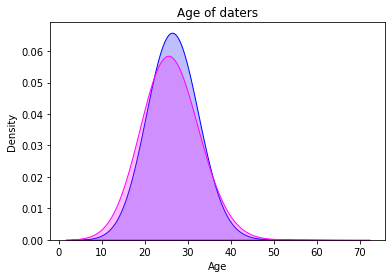

In [ ]:
sns.kdeplot(data[data.gender == 1].age,
            bw=1.5, shade=True, color='blue', label='men')
sns.kdeplot(data[data.gender == 0].age,
            bw=1.5, shade=True, color='magenta', label='women')
plt.title('Age of daters')
plt.xlabel('Age');

Text(0.5, 0, 'Zip code median income')

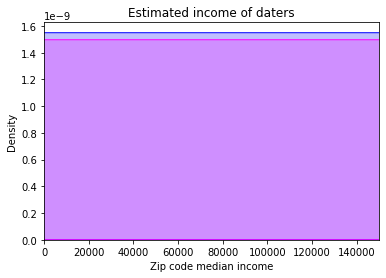

In [ ]:
sns.kdeplot(data[(data.gender == 1) & (data.income > 0)].income,
            bw=15000, shade=True, color='blue', label='men')
sns.kdeplot(data[(data.gender == 0) & (data.income > 0)].income,
            bw=15000, shade=True, color='magenta', label='women')
plt.title('Estimated income of daters')

plt.xlim(0,150000)
plt.xlabel('Zip code median income')

# Trying Different Classifiers

I did some experimentation with adjusting the hyperparameters of each model below. Each score is fairly representative of the algorithm's best performance.

In [ ]:
def polynomial_kernel(X, Y, degree=3, gamma=1, coef0=1):
    """
    Polynomial kernel implementation for SVM using NumPy.
    
    Args:
        X (ndarray): Input data with shape (n_samples_X, n_features).
        Y (ndarray): Input data with shape (n_samples_Y, n_features).
        degree (int): Degree of the polynomial kernel function.
        gamma (float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
        coef0 (float): Independent term in kernel function. It is only significant
            in 'poly' and 'sigmoid'.
        
    Returns:
        K (ndarray): Computed kernel matrix with shape (n_samples_X, n_samples_Y).
    """
    K = np.dot(X, Y.T)
    K = (gamma * K + coef0) ** degree
    
    return K

In [ ]:

def experiment_model(X_train,y_train,X_test):
    result_list = []
    # Define the parameter grid for gamma and C
    param_grid = {'gamma': [0.01,0.1, 1, 10], 'C': [0.01,0.1, 1, 10,100]}

    # Initialize the SVM with a rbf kernel
    svm_model = SVC(kernel='rbf')
    clf_one = GridSearchCV(estimator=svm_model, param_grid=param_grid,cv=4, scoring='f1')
    clf_one.fit(X_train, y_train)
    Predicted_labels= clf_one.predict(X_test)
    result_list.append((Predicted_labels,clf_one))
    print(f"SVM , Kernal = RBF , Best parameters: {clf_one.best_params_}")

    # Define the parameter grid for gamma and C
    # param_grid = {'C': [0.1, 1, 10]}
    # svm_model = SVC(kernel='linear')
    # clf_two = GridSearchCV(estimator=svm_model, param_grid=param_grid)
    # clf_two.fit(X_train, y_train)
    # Predicted_labels= clf_two.predict(X_test)
    # result_list.append((Predicted_labels,clf_two))
    # print(f"SVM , Kernel = Linear ,Best parameters: {clf_two.best_params_}")


    #Initialize the SVM with a polynomial kernel
    # param_grid = {"degree": [2, 3, 4],"C": [ 0.1, 1, 10]}
    # svm_model = SVC(kernel='poly')
    # clf_five = GridSearchCV(estimator=svm_model, param_grid=param_grid,cv=4, scoring='f1')
    # clf_five.fit(X_train, y_train)
    # Predicted_labels= clf_five.predict(X_test)
    # result_list.append((Predicted_labels,clf_five))
    # print(f"SVM , Kernel = Poly , Best parameters: {clf_five.best_params_}")

    
    param_grid = {'gamma': [0.01,0.1, 1, 10], 'C': [0.01,0.1, 1, 10,100]}

    # Initialize the SVM with a Sigmoid kernel
    svm_model = SVC(kernel='sigmoid')
    clf_six = GridSearchCV(estimator=svm_model, param_grid=param_grid,cv=4, scoring='f1')
    clf_six.fit(X_train, y_train)
    Predicted_labels= clf_six.predict(X_test)
    result_list.append((Predicted_labels,clf_six))
    print(f"SVM , Kernel = Sigmoid , Best parameters: {clf_six.best_params_}")


    # print("SVM , Kernel = Manual, ")

    # Create an SVM model with Polynomial kernel
    # clf_seven = SVC(kernel=polynomial_kernel)

    # Fit the model to your data
    # clf_seven.fit(X_train, y_train)
    # Predicted_labels= clf_seven.predict(X_test)
    # result_list.append((Predicted_labels,clf_seven))



    return result_list

I did some experimentation with adjusting the hyperparameters of each model below. Each score is fairly representative of the algorithm's best performance.

In [ ]:


from sklearn.model_selection import train_test_split, GridSearchCV

x = data.drop('match', axis=1)
y = data['match']

# Fixing a csv import bug
for i in x.columns:
    if 'Unnamed' in i:
        del x[i]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2)

xtrain.shape



(4608, 418)

In [ ]:
res_list = experiment_model(xtrain,ytrain,xtest)

SVM , Kernal = RBF , Best parameters: {'C': 0.01, 'gamma': 0.01}
SVM , Kernel = Sigmoid , Best parameters: {'C': 1, 'gamma': 0.01}


In [ ]:
def show_metric(y_test,Predicted_labels):
  
    confu = confusion_matrix(y_test,Predicted_labels,labels=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=confu,display_labels=["0","1"])
    disp.plot()
    ACC = accuracy_score(y_test,Predicted_labels)
    Rec = recall_score(y_test,Predicted_labels)
    Precision = precision_score(y_test,Predicted_labels)
    f1score = f1_score(y_test,Predicted_labels)
    print("ACC is :",ACC ,"\nRec is :",Rec,"\nPersision is : ",Precision,"\nF1 Score is :",f1score)

ACC is : 0.8326105810928014 
Rec is : 0.0 
Persision is :  0.0 
F1 Score is : 0.0


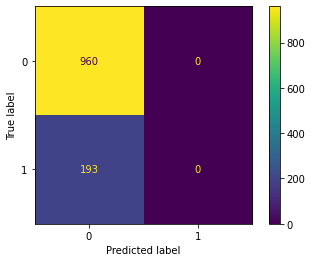

In [ ]:
show_metric(ytest,res_list[0][0])

ACC is : 0.7285342584562012 
Rec is : 0.18134715025906736 
Persision is :  0.18421052631578946 
F1 Score is : 0.18276762402088773


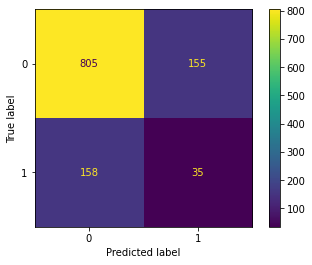

In [ ]:
show_metric(ytest,res_list[1][0])

In [ ]:
from sklearn.decomposition import PCA

pca100 = PCA(n_components=100)
trainx_pca100 = pca100.fit_transform(xtrain)
testx_pac100 = pca100.transform(xtest)

pca30 = PCA(n_components=30)
trainx_pca30 = pca30.fit_transform(xtrain)
testx_pac30 = pca30.transform(xtest)



In [ ]:
trainx_pca100.shape

(4608, 100)

In [ ]:
res_list_100 = experiment_model(trainx_pca100,ytrain,testx_pac100)

SVM , Kernal = RBF , Best parameters: {'C': 0.01, 'gamma': 0.01}
SVM , Kernel = Sigmoid , Best parameters: {'C': 10, 'gamma': 0.01}


ACC is : 0.8326105810928014 
Rec is : 0.0 
Persision is :  0.0 
F1 Score is : 0.0


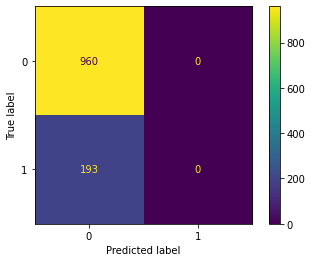

In [ ]:
show_metric(ytest,res_list_100[0][0])

ACC is : 0.7241977450130095 
Rec is : 0.17098445595854922 
Persision is :  0.17277486910994763 
F1 Score is : 0.17187500000000003


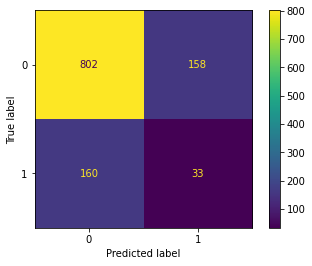

In [ ]:
show_metric(ytest,res_list_100[1][0])

In [ ]:
res_list_30 = experiment_model(trainx_pca30,ytrain,testx_pac30)

SVM , Kernal = RBF , Best parameters: {'C': 10, 'gamma': 0.01}
SVM , Kernel = Sigmoid , Best parameters: {'C': 10, 'gamma': 0.01}


ACC is : 0.8282740676496098 
Rec is : 0.02072538860103627 
Persision is :  0.3076923076923077 
F1 Score is : 0.038834951456310676


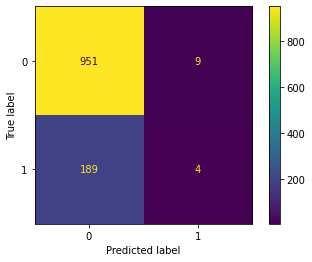

In [ ]:
show_metric(ytest,res_list_30[0][0])

ACC is : 0.7241977450130095 
Rec is : 0.17098445595854922 
Persision is :  0.17277486910994763 
F1 Score is : 0.17187500000000003


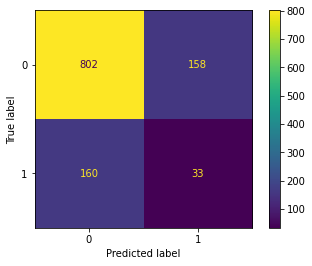

In [ ]:
show_metric(ytest,res_list_30[1][0])

**LLE**

***LLE (Locally Linear Embedding):*** This is another nonlinear dimensionality reduction technique that preserves the local structure of the data.

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
embedding300 = LocallyLinearEmbedding(n_components=300)
xtrain_embedding300 = embedding300.fit_transform(xtrain)
xtest_embedding300= embedding300.transform(xtest)



In [ ]:
res_list_embedding300 = experiment_model(xtrain_embedding300,ytrain,xtest_embedding300)

SVM , Kernal = RBF , Best parameters: {'C': 100, 'gamma': 10}
SVM , Kernel = Sigmoid , Best parameters: {'C': 100, 'gamma': 10}


ACC is : 0.8169991326973114 
Rec is : 0.029556650246305417 
Persision is :  0.3 
F1 Score is : 0.0538116591928251


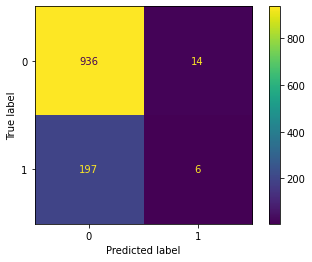

In [ ]:
show_metric(ytest,res_list_embedding300[0][0])

ACC is : 0.8013876843018214 
Rec is : 0.08374384236453201 
Persision is :  0.2833333333333333 
F1 Score is : 0.12927756653992395


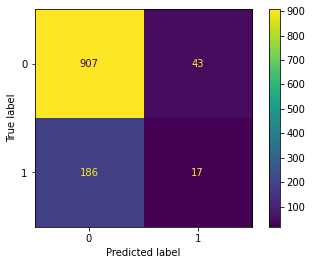

In [ ]:
show_metric(ytest,res_list_embedding300[1][0])

In [ ]:
embedding200 = LocallyLinearEmbedding(n_components=200)
xtrain_embedding200 = embedding200.fit_transform(xtrain)
xtest_embedding200= embedding200.transform(xtest)


In [ ]:
res_list_embedding200 = experiment_model(xtrain_embedding200,ytrain,xtest_embedding200)

SVM , Kernal = RBF , Best parameters: {'C': 100, 'gamma': 1}
SVM , Kernel = Sigmoid , Best parameters: {'C': 100, 'gamma': 10}


ACC is : 0.8196010407632264 
Rec is : 0.024630541871921183 
Persision is :  0.3333333333333333 
F1 Score is : 0.045871559633027525


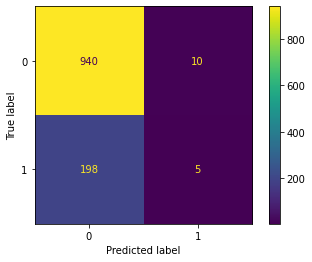

In [ ]:
show_metric(ytest,res_list_embedding200[0][0])

ACC is : 0.7779705117085863 
Rec is : 0.061452513966480445 
Persision is :  0.1111111111111111 
F1 Score is : 0.07913669064748202


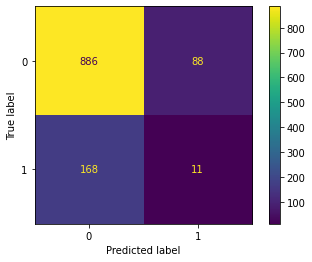

In [ ]:
show_metric(ytest,res_list_embedding200[1][0])

In [ ]:
embedding30 = LocallyLinearEmbedding(n_components=30)
xtrain_embedding30 = embedding30.fit_transform(xtrain)
xtest_embedding30= embedding30.transform(xtest)


In [ ]:
res_list_embedding30 = experiment_model(xtrain_embedding30,ytrain,xtest_embedding30)

SVM , Kernal = RBF , Best parameters: {'C': 100, 'gamma': 10}
SVM , Kernel = Sigmoid , Best parameters: {'C': 100, 'gamma': 10}


ACC is : 0.8256721595836947 
Rec is : 0.025252525252525252 
Persision is :  0.38461538461538464 
F1 Score is : 0.04739336492890995


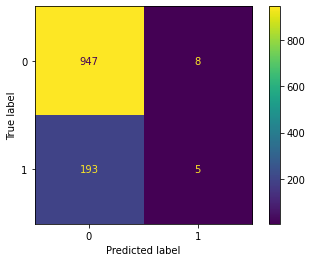

In [ ]:
show_metric(ytest,res_list_embedding30[0][0])

ACC is : 0.8256721595836947 
Rec is : 0.025252525252525252 
Persision is :  0.38461538461538464 
F1 Score is : 0.04739336492890995


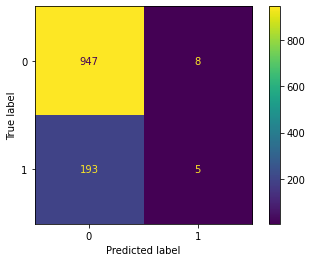

In [ ]:
show_metric(ytest,res_list_embedding30[1][0])

**Try to give better model by change weight**

In [ ]:
from sklearn.svm import SVC
from sklearn.utils import class_weight

# Assume you have training data stored in X_train and y_train
# y_train is a binary class variable (0 or 1) with many 0s and only a few 1s

# Compute the class weights
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=ytrain)

# # Train the SVM classifier with the computed class weights
# clf = SVC(kernel='linear', class_weight={0: class_weights[0], 1: class_weights[1]})
# clf.fit(X_train, y_train)

In [ ]:
print(class_weights)

[0.59921977 3.01965924]


I change experiment model function with this approch because I have alot of zero label and few one label , I give more to one weight to predict one label as good ass zero label .

In [ ]:
def experiment_model(X_train,y_train,X_test,class_weights):
    result_list = []
    # Define the parameter grid for gamma and C
    param_grid = {'gamma': [0.01,0.1, 1, 10], 'C': [0.01,0.1, 1, 10,100]}

    # Initialize the SVM with a rbf kernel
    svm_model = SVC(kernel='rbf',class_weight={0: class_weights[0], 1: class_weights[1]})
    clf_one = GridSearchCV(estimator=svm_model, param_grid=param_grid,cv=4, scoring='f1')
    clf_one.fit(X_train, y_train)
    Predicted_labels= clf_one.predict(X_test)
    result_list.append((Predicted_labels,clf_one))
    print(f"SVM , Kernal = RBF , Best parameters: {clf_one.best_params_}")

    
    param_grid = {'gamma': [0.01,0.1, 1, 10], 'C': [0.01,0.1, 1, 10,100]}
    # Initialize the SVM with a Sigmoid kernel
    svm_model = SVC(kernel='sigmoid',class_weight={0: class_weights[0], 1: class_weights[1]})
    clf_six = GridSearchCV(estimator=svm_model, param_grid=param_grid,cv=4, scoring='f1')
    clf_six.fit(X_train, y_train)
    Predicted_labels= clf_six.predict(X_test)
    result_list.append((Predicted_labels,clf_six))
    print(f"SVM , Kernel = Sigmoid , Best parameters: {clf_six.best_params_}")


    # print("SVM , Kernel = Manual, ")

    # Create an SVM model with Polynomial kernel
    # clf_seven = SVC(kernel=polynomial_kernel)

    # Fit the model to your data
    # clf_seven.fit(X_train, y_train)
    # Predicted_labels= clf_seven.predict(X_test)
    # result_list.append((Predicted_labels,clf_seven))



    return result_list

In [ ]:
res_list = experiment_model(xtrain,ytrain,xtest,class_weights)

SVM , Kernal = RBF , Best parameters: {'C': 0.01, 'gamma': 0.01}
SVM , Kernel = Sigmoid , Best parameters: {'C': 10, 'gamma': 0.01}


ACC is : 0.16652211621856028 
Rec is : 1.0 
Persision is :  0.16652211621856028 
F1 Score is : 0.2855018587360595


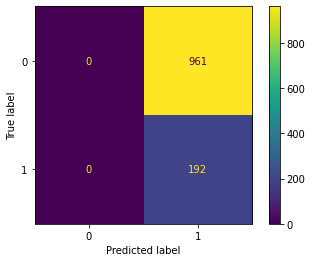

In [ ]:
show_metric(ytest,res_list[0][0])

ACC is : 0.36253252385082396 
Rec is : 0.640625 
Persision is :  0.155893536121673 
F1 Score is : 0.2507645259938838


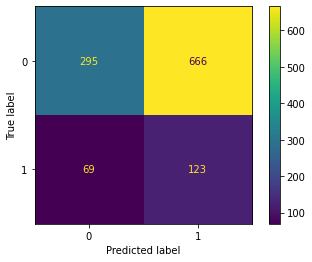

In [ ]:
show_metric(ytest,res_list[1][0])

**change weight**



In [ ]:
class_weights = [1,2.5]

In [ ]:
res_list = experiment_model(xtrain,ytrain,xtest,class_weights)

SVM , Kernal = RBF , Best parameters: {'C': 0.01, 'gamma': 0.01}
SVM , Kernel = Sigmoid , Best parameters: {'C': 0.01, 'gamma': 0.01}


ACC is : 0.17606244579358196 
Rec is : 1.0 
Persision is :  0.17606244579358196 
F1 Score is : 0.2994100294985251


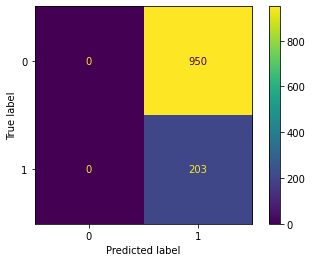

In [ ]:
show_metric(ytest,res_list[0][0])

ACC is : 0.45446660884648743 
Rec is : 0.46798029556650245 
Persision is :  0.15422077922077923 
F1 Score is : 0.231990231990232


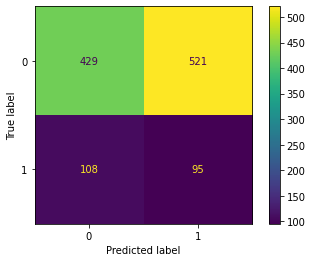

In [ ]:
show_metric(ytest,res_list[1][0])

In [ ]:
class_weights = [1.5,2.5]

In [ ]:
res_list = experiment_model(xtrain,ytrain,xtest,class_weights)

SVM , Kernal = RBF , Best parameters: {'C': 0.01, 'gamma': 0.01}
SVM , Kernel = Sigmoid , Best parameters: {'C': 0.01, 'gamma': 0.01}


ACC is : 0.823937554206418 
Rec is : 0.0 
Persision is :  0.0 
F1 Score is : 0.0


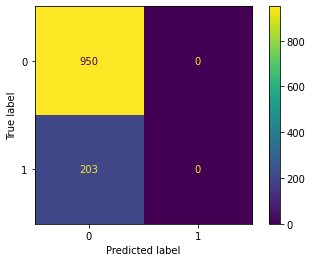

In [ ]:
show_metric(ytest,res_list[0][0])

ACC is : 0.6227233304423244 
Rec is : 0.31527093596059114 
Persision is :  0.17777777777777778 
F1 Score is : 0.22735346358792186


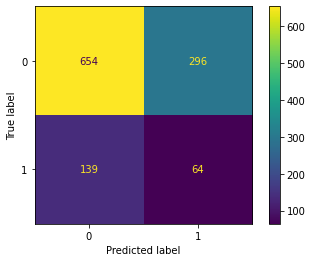

In [ ]:
show_metric(ytest,res_list[1][0])

In [ ]:
def find_best_weight(X_train, y_train,X_test):

      param_grid = {'C': [0.1, 1, 10, 100],
                    'gamma': [0.001, 0.01, 0.1, 1],
                    'kernel': ['sigmoid']}
      svm = SVC(class_weight='balanced')
      grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5,scoring='f1')
      grid_search.fit(X_train, y_train)

      print("Best parameters: ", grid_search.best_params_)
      print("Best score:", grid_search.best_score_)


In [ ]:
find_best_weight(xtrain,ytrain,xtest)

Best parameters:  {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best score: 0.2685772432845176


In [ ]:
svm = SVC(class_weight='balanced',C=100,gamma=0.001,kernel='sigmoid')


In [ ]:
svm.fit(xtrain,ytrain)

SVC(C=1, class_weight='balanced', gamma=0.001, kernel='sigmoid')

In [ ]:
ypredict = svm.predict(xtest)

ACC is : 0.45099739809193407 
Rec is : 0.45320197044334976 
Persision is :  0.1498371335504886 
F1 Score is : 0.22521419828641376


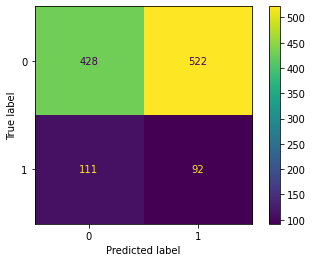

In [ ]:
show_metric(ytest,ypredict)

In [ ]:
def find_best_weight(X_train, y_train,X_test):

      param_grid = {'C': [0.1, 1, 10, 100],
                    'gamma': [0.001, 0.01, 0.1, 1],
                    'kernel': ['rbf']}
      svm = SVC(class_weight='balanced')
      grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5,scoring='f1')
      grid_search.fit(X_train, y_train)

      print("Best parameters: ", grid_search.best_params_)
      print("Best score:", grid_search.best_score_)

In [ ]:
find_best_weight(xtrain,ytrain,xtest)

Best parameters:  {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best score: 0.28411781789809054


In [ ]:
svm = SVC(class_weight='balanced',C= 0.1,gamma=0.01,kernel='rbf')


In [ ]:
svm.fit(xtrain,ytrain)

SVC(C=0.1, class_weight='balanced', gamma=0.01)

In [ ]:
ypredict = svm.predict(xtest)

ACC is : 0.17606244579358196 
Rec is : 1.0 
Persision is :  0.17606244579358196 
F1 Score is : 0.2994100294985251


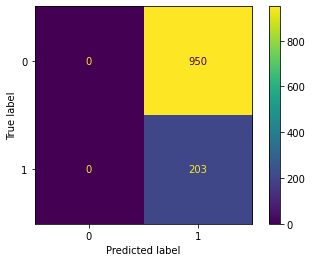

In [ ]:
show_metric(ytest,ypredict)

**Use Pcf now**

In [ ]:
svm = SVC(class_weight='balanced',C=1,gamma=0.001,kernel='rbf')


In [ ]:
svm.fit(trainx_pca100,ytrain)

SVC(C=1, class_weight='balanced', gamma=0.001)

In [ ]:
ypredict = svm.predict(testx_pac100)

ACC is : 0.795316565481353 
Rec is : 0.15083798882681565 
Persision is :  0.24324324324324326 
F1 Score is : 0.18620689655172415


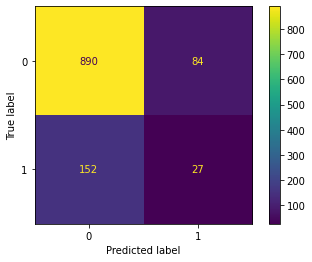

In [ ]:
show_metric(ytest,ypredict) 

In [ ]:
svm = SVC(class_weight='balanced',C=1,gamma=0.001,kernel='sigmoid')


In [ ]:
svm.fit(trainx_pca30,ytrain)

SVC(C=1, class_weight='balanced', gamma=0.001, kernel='sigmoid')

In [ ]:
ypredict = svm.predict(testx_pac30)

ACC is : 0.49522983521248914 
Rec is : 0.5073891625615764 
Persision is :  0.17606837606837608 
F1 Score is : 0.2614213197969543


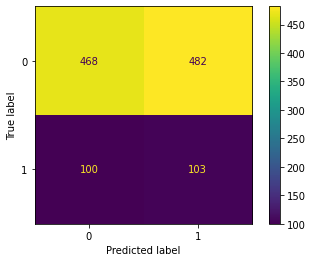

In [ ]:
show_metric(ytest,ypredict) 

**LLE**

***LLE (Locally Linear Embedding):*** This is another nonlinear dimensionality reduction technique that preserves the local structure of the data.


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

ACC is : 0.5706851691240243 
Rec is : 0.5533980582524272 
Persision is :  0.2205029013539652 
F1 Score is : 0.3153526970954357


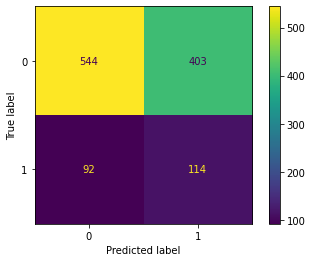

In [ ]:
embedding300 = LocallyLinearEmbedding(n_components=300)
xtrain_embedding300 = embedding300.fit_transform(xtrain)
xtest_embedding300= embedding300.transform(xtest)
  
svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='sigmoid')

svm.fit(xtrain_embedding300,ytrain)

ypredict = svm.predict(xtest_embedding300)

show_metric(ytest,ypredict) 


ACC is : 0.5784908933217693 
Rec is : 0.5631067961165048 
Persision is :  0.2265625 
F1 Score is : 0.3231197771587744


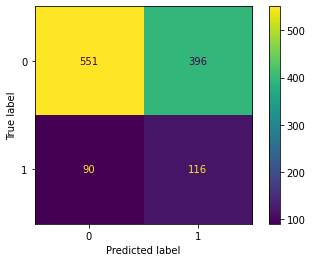

In [ ]:
embedding300 = LocallyLinearEmbedding(n_components=300)
xtrain_embedding300 = embedding300.fit_transform(xtrain)
xtest_embedding300= embedding300.transform(xtest)

svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='rbf')

svm.fit(xtrain_embedding300,ytrain)

ypredict = svm.predict(xtest_embedding300)

show_metric(ytest,ypredict) 

ACC is : 0.5117085862966175 
Rec is : 0.5825242718446602 
Persision is :  0.20100502512562815 
F1 Score is : 0.29887920298879206


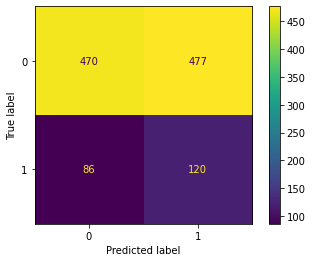

In [ ]:
embedding200 = LocallyLinearEmbedding(n_components=200)
xtrain_embedding200 = embedding200.fit_transform(xtrain)
xtest_embedding200= embedding200.transform(xtest)

svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='sigmoid')

svm.fit(xtrain_embedding200,ytrain)

ypredict = svm.predict(xtest_embedding200)

show_metric(ytest,ypredict) 

ACC is : 0.6027753686036427 
Rec is : 0.5048543689320388 
Persision is :  0.22608695652173913 
F1 Score is : 0.31231231231231227


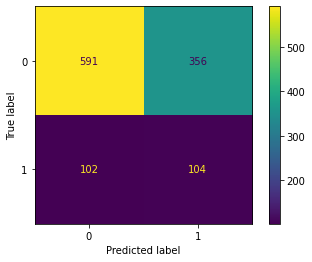

In [ ]:
embedding200 = LocallyLinearEmbedding(n_components=200)
xtrain_embedding200 = embedding200.fit_transform(xtrain)
xtest_embedding200= embedding200.transform(xtest)

svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='rbf')

svm.fit(xtrain_embedding200,ytrain)

ypredict = svm.predict(xtest_embedding200)

show_metric(ytest,ypredict) 

ACC is : 0.5845620121422377 
Rec is : 0.46601941747572817 
Persision is :  0.2064516129032258 
F1 Score is : 0.28614008941877794


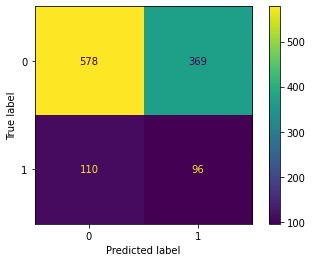

In [ ]:
embedding100 = LocallyLinearEmbedding(n_components=100)
xtrain_embedding100 = embedding100.fit_transform(xtrain)
xtest_embedding100= embedding100.transform(xtest)

svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='sigmoid')

svm.fit(xtrain_embedding100,ytrain)

ypredict = svm.predict(xtest_embedding100)

show_metric(ytest,ypredict) 

ACC is : 0.601040763226366 
Rec is : 0.5145631067961165 
Persision is :  0.22746781115879827 
F1 Score is : 0.31547619047619047


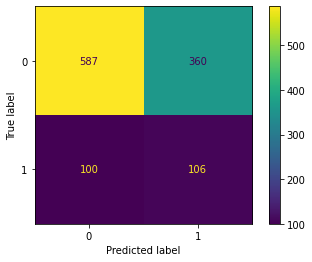

In [ ]:
embedding100 = LocallyLinearEmbedding(n_components=100)
xtrain_embedding100 = embedding100.fit_transform(xtrain)
xtest_embedding100= embedding100.transform(xtest)

svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='rbf')

svm.fit(xtrain_embedding100,ytrain)

ypredict = svm.predict(xtest_embedding100)

show_metric(ytest,ypredict) 

ACC is : 0.5117085862966175 
Rec is : 0.5825242718446602 
Persision is :  0.20100502512562815 
F1 Score is : 0.29887920298879206


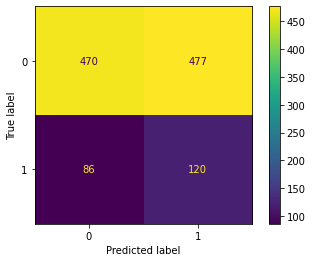

In [ ]:
embedding30 = LocallyLinearEmbedding(n_components=30)
xtrain_embedding30 = embedding200.fit_transform(xtrain)
xtest_embedding30= embedding200.transform(xtest)

svm = SVC(class_weight='balanced',C=100,gamma=10,kernel='sigmoid')

svm.fit(xtrain_embedding30,ytrain)

ypredict = svm.predict(xtest_embedding30)

show_metric(ytest,ypredict) 

# **Use cross ‫‪validation‬‬**



**K=3**

In [ ]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro','f1','accuracy']
clf = SVC(kernel='sigmoid', C=1,gamma=0.01)

scores = cross_validate(clf, x, y, scoring=scoring,cv=3)

In [ ]:
scores

{'fit_time': array([0.97887063, 0.8592937 , 0.89325595]),
 'score_time': array([0.37488461, 0.3630228 , 0.36449432]),
 'test_precision_macro': array([0.48649863, 0.50940486, 0.47266249]),
 'test_recall_macro': array([0.47761509, 0.50846749, 0.47966013]),
 'test_f1': array([0.20588235, 0.17190083, 0.09854015]),
 'test_accuracy': array([0.57834461, 0.7390625 , 0.74270833])}

In [ ]:
clf = SVC(kernel='sigmoid', C=0.01,gamma=0.01,class_weight='balanced')

scores = cross_validate(clf, x, y, scoring=scoring,cv=3)

In [ ]:
scores

{'fit_time': array([2.38614178, 2.1116221 , 2.08915544]),
 'score_time': array([0.8687849 , 0.87359047, 0.79191089]),
 'test_precision_macro': array([0.48503785, 0.51931424, 0.48858252]),
 'test_recall_macro': array([0.48740964, 0.53320921, 0.48714426]),
 'test_f1': array([0.12692967, 0.28629579, 0.16068867]),
 'test_accuracy': array([0.73503384, 0.45208333, 0.6953125 ])}

In [ ]:
clf = SVC(kernel='sigmoid', C=1,gamma=0.01)

scores = cross_validate(clf, x, y, scoring=scoring,cv=3)

In [ ]:
scores

{'fit_time': array([5.37591672, 1.7553494 , 1.69465065, 1.60810447, 2.23305511]),
 'score_time': array([0.26435947, 0.25993109, 0.26148582, 0.34559488, 0.35210156]),
 'test_precision_macro': array([0.46759701, 0.48797283, 0.49702729, 0.51820837, 0.53739006]),
 'test_recall_macro': array([0.45621244, 0.49297898, 0.49814412, 0.5126292 , 0.53785247]),
 'test_f1': array([0.14403292, 0.10135135, 0.11842105, 0.1572327 , 0.23136247]),
 'test_accuracy': array([0.63920208, 0.76909722, 0.76736111, 0.76736111, 0.74045139])}

**K=5**

In [ ]:
clf = SVC(kernel='sigmoid', C=1,gamma=0.01)

scores = cross_validate(clf, x, y, scoring=scoring,cv=5)

In [ ]:
scores

{'fit_time': array([1.00622082, 0.85937715, 0.6346705 , 0.70443249, 0.95427632]),
 'score_time': array([0.13303971, 0.13734436, 0.12854052, 0.13326001, 0.16690898]),
 'test_precision_macro': array([0.46759701, 0.48797283, 0.49702729, 0.51820837, 0.53739006]),
 'test_recall_macro': array([0.45621244, 0.49297898, 0.49814412, 0.5126292 , 0.53785247]),
 'test_f1': array([0.14403292, 0.10135135, 0.11842105, 0.1572327 , 0.23136247]),
 'test_accuracy': array([0.63920208, 0.76909722, 0.76736111, 0.76736111, 0.74045139])}

In [ ]:
clf = SVC(kernel='sigmoid', C=0.01,gamma=0.01,class_weight='balanced')

scores = cross_validate(clf, x, y, scoring=scoring,cv=5)

In [ ]:
scores

{'fit_time': array([5.64966083, 6.13062835, 4.66483164, 5.06069756, 6.68122935]),
 'score_time': array([1.01914406, 0.65974212, 0.46258044, 0.92395067, 0.5735023 ]),
 'test_precision_macro': array([0.43062771, 0.48670369, 0.52299172, 0.51974657, 0.51127366]),
 'test_recall_macro': array([0.48621846, 0.4775538 , 0.54082404, 0.52071188, 0.51990145]),
 'test_f1': array([0.28006088, 0.20952381, 0.28848485, 0.20603015, 0.26074499]),
 'test_accuracy': array([0.17953166, 0.56770833, 0.49045139, 0.72569444, 0.55208333])}

**K=7**

In [ ]:
clf = SVC(kernel='sigmoid', C=1,gamma=0.01)

scores = cross_validate(clf, x, y, scoring=scoring,cv=7)

In [ ]:
scores

{'fit_time': array([2.56014848, 2.43358827, 2.44910765, 2.5730207 , 2.6834805 ,
        2.24357724, 2.54140639]),
 'score_time': array([0.20396805, 0.20348883, 0.20718575, 0.28636479, 0.20137119,
        0.19960809, 0.19486976]),
 'test_precision_macro': array([0.47853481, 0.45258169, 0.5633265 , 0.50678137, 0.55415174,
        0.44935047, 0.51780837]),
 'test_recall_macro': array([0.47457421, 0.43966995, 0.52877393, 0.50468634, 0.5351846 ,
        0.47286047, 0.51545012]),
 'test_f1': array([0.1483871 , 0.1097561 , 0.16494845, 0.14096916, 0.19909502,
        0.04878049, 0.18110236]),
 'test_accuracy': array([0.67922236, 0.64520049, 0.80315917, 0.76306197, 0.78493317,
        0.76306197, 0.7472661 ])}

In [ ]:
clf = SVC(kernel='sigmoid', C=0.01,gamma=0.01,class_weight='balanced')

scores = cross_validate(clf, x, y, scoring=scoring,cv=7)

In [ ]:
scores

{'fit_time': array([6.17551804, 3.97874713, 2.2987628 , 2.29381776, 2.38020921,
        2.48980689, 2.6149683 ]),
 'score_time': array([0.43813872, 0.22808146, 0.25832033, 0.21347237, 0.22805595,
        0.28696012, 0.22434139]),
 'test_precision_macro': array([0.50156887, 0.4842462 , 0.4986688 , 0.52439259, 0.53469997,
        0.47699208, 0.51952257]),
 'test_recall_macro': array([0.50276632, 0.48795092, 0.49775204, 0.54292817, 0.5620914 ,
        0.47989527, 0.52860997]),
 'test_f1': array([0.24497992, 0.11764706, 0.26234568, 0.29139073, 0.30223881,
        0.11764706, 0.28965517]),
 'test_accuracy': array([0.54313487, 0.74483597, 0.41919806, 0.4799514 , 0.54556501,
        0.72660996, 0.37424058])}

**K=10**

In [ ]:
clf = SVC(kernel='sigmoid', C=1,gamma=0.01)

scores = cross_validate(clf, x, y, scoring=scoring,cv=10)

In [ ]:
scores

{'fit_time': array([3.02801704, 3.37361813, 2.77656031, 2.76349163, 2.8059175 ,
        3.24257183, 2.65500665, 2.57906461, 2.55921364, 3.15304565]),
 'score_time': array([0.15892768, 0.14470792, 0.14812946, 0.15433335, 0.17985344,
        0.15672135, 0.15449524, 0.15284848, 0.15396166, 0.21177554]),
 'test_precision_macro': array([0.49248455, 0.46855631, 0.45784431, 0.59375   , 0.44645573,
        0.55012771, 0.56460745, 0.45817369, 0.46755537, 0.46529909]),
 'test_recall_macro': array([0.49420103, 0.459375  , 0.465625  , 0.53541667, 0.465625  ,
        0.5304113 , 0.54985688, 0.47462497, 0.4829757 , 0.45838624]),
 'test_f1': array([0.13095238, 0.13852814, 0.08187135, 0.171875  , 0.05228758,
        0.18543046, 0.23809524, 0.06622517, 0.06993007, 0.12727273]),
 'test_accuracy': array([0.74696707, 0.65451389, 0.72743056, 0.81597222, 0.74826389,
        0.78645833, 0.77777778, 0.75520833, 0.76909722, 0.66666667])}

In [ ]:
clf = SVC(kernel='sigmoid', C=0.01,gamma=0.01,class_weight='balanced')

scores = cross_validate(clf, x, y, scoring=scoring,cv=10)

In [ ]:
scores

{'fit_time': array([6.98699594, 7.93514538, 7.11594939, 5.88561821, 7.48958111,
        7.70052528, 7.50240564, 7.53732467, 6.66399765, 7.78293204]),
 'score_time': array([0.56388974, 0.51835132, 0.42575288, 0.34615898, 0.47128081,
        0.3794167 , 0.37377381, 0.46061826, 0.42298532, 0.40573788]),
 'test_precision_macro': array([0.50624228, 0.47178131, 0.48922559, 0.50347373, 0.53459577,
        0.52165218, 0.52986597, 0.49491597, 0.48377679, 0.48713324]),
 'test_recall_macro': array([0.51107174, 0.45      , 0.490625  , 0.50625   , 0.55520833,
        0.53775047, 0.55294535, 0.49479155, 0.47165487, 0.47927383]),
 'test_f1': array([0.25555556, 0.1954023 , 0.13559322, 0.25396825, 0.3035343 ,
        0.28904429, 0.29362881, 0.16243655, 0.23887588, 0.20338983]),
 'test_accuracy': array([0.5355286 , 0.51388889, 0.734375  , 0.51041667, 0.41840278,
        0.47048611, 0.55729167, 0.71354167, 0.43576389, 0.59201389])}

**Change C and See effect of it**

In [ ]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
import mlxtend

In [ ]:
mlxtend.__version__

'0.21.0'

In [ ]:
from sklearn.metrics import accuracy_score


Cs = np.logspace(-3, 3, 7)

list_bias = []
list_var = []
list_acc = []
list_f1 = []
# Loop over different values for parameter C, and print bias and variance
for C in Cs:
    svc = SVC(kernel='sigmoid',gamma=0.01, C=C)
    svc.fit(xtrain, ytrain)

    y_pred = svc.predict(xtest)
    # calculate accuracy score and bias/variance
    acc = accuracy_score(ytest, y_pred)
    bias = 1 - acc
    var = svc.score(xtrain, ytrain) - acc
    f1 = f1_score(ytest, y_pred)
    list_bias.append(bias)
    list_var.append(var)
    list_acc.append(acc)
    list_f1.append(f1)

    print("C = {},f1_score = {:.3f} accuracy = {:.3f}, bias = {:.3f}, variance = {:.3f}".format(C,f1, acc, bias, var))



C = 0.001,f1_score = 0.000 accuracy = 0.832, bias = 0.168, variance = 0.001
C = 0.01,f1_score = 0.049 accuracy = 0.800, bias = 0.200, variance = 0.004
C = 0.1,f1_score = 0.049 accuracy = 0.800, bias = 0.200, variance = 0.004
C = 1.0,f1_score = 0.124 accuracy = 0.742, bias = 0.258, variance = 0.008
C = 10.0,f1_score = 0.124 accuracy = 0.742, bias = 0.258, variance = 0.008
C = 100.0,f1_score = 0.124 accuracy = 0.742, bias = 0.258, variance = 0.008
C = 1000.0,f1_score = 0.124 accuracy = 0.742, bias = 0.258, variance = 0.008


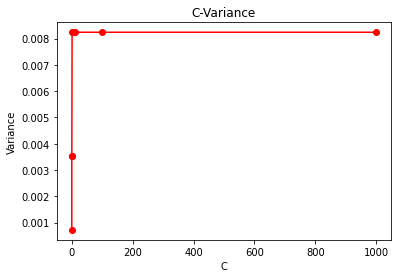

In [ ]:
 # Plot the bias and variance
plt.plot(Cs, list_var, marker='o', color="red")
    
plt.xlabel("C")
plt.ylabel("Variance")
plt.title("C-Variance")
plt.show()

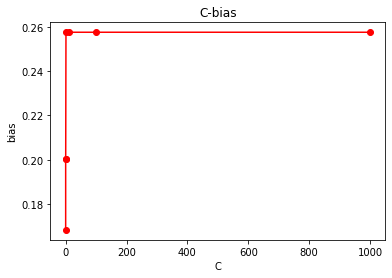

In [ ]:
plt.plot(Cs, list_bias, marker='o', color="red")
    
plt.xlabel("C")
plt.ylabel("bias")
plt.title("C-bias")
plt.show()

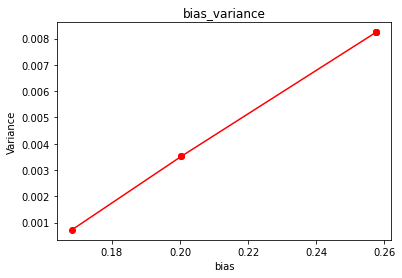

In [ ]:
plt.plot(list_bias, list_var, marker='o', color="red")
    
plt.xlabel("bias")
plt.ylabel("Variance")
plt.title("bias_variance")
plt.show()